In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


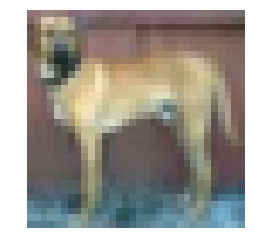

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [21]:
def conv_net(inputs, keep_prob, is_training):   
    
    # Conv Layer - 1, Input 32x32x3 -> BatchNorm -> eLU -> MaxPooling -> Output 16x16x32
    conv1_layer = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_layer_norm = tf.layers.batch_normalization(conv1_layer, training=is_training)
    conv1_layer_activated = tf.nn.elu(conv1_layer_norm)
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer_activated, pool_size=2, strides=2)
    conv1_layer_dropout = tf.nn.dropout(conv1_layer_mpool, keep_prob)
    
    # Conv Layer - 2, Input 16x16x16 -> BatchNorm -> eLU -> MaxPooling -> Output 8x8x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_dropout, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", activation=None, 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_layer_norm = tf.layers.batch_normalization(conv2_layer, training=is_training)
    conv2_layer_activated = tf.nn.elu(conv2_layer_norm)
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer_activated, pool_size=2, strides=2)
    conv2_layer_dropout = tf.nn.dropout(conv2_layer_mpool, keep_prob)

    # Conv Layer - 3, Input 8x8x32 -> BatchNorm -> eLU -> MaxPooling -> Output 4x4x64
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_dropout, filters=64, kernel_size=3, strides=1,
                                   padding="SAME", activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_layer_norm = tf.layers.batch_normalization(conv3_layer, training=is_training)
    conv3_layer_activated = tf.nn.elu(conv3_layer_norm)
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer_activated, pool_size=2, strides=2)
    conv3_layer_dropout = tf.nn.dropout(conv3_layer_mpool, keep_prob)
    
    # Conv Layer Flattened
    conv_output_shape = conv3_layer_mpool.get_shape().as_list()
    flatten=tf.reshape(conv3_layer_dropout,
                       [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])
    
    # Dense Layer - 1, Size 384 -> Dropout
    dense1_layer = tf.layers.dense(inputs=flatten, units=384, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense1_layer_norm = tf.layers.batch_normalization(dense1_layer, training=is_training)
    dense1_layer_activated = tf.nn.elu(dense1_layer_norm)
    dense1_layer_dropout = tf.nn.dropout(dense1_layer_activated, keep_prob)
    
    # Dense Layer - 2, Size 128 -> Dropout
    dense2_layer = tf.layers.dense(inputs=dense1_layer_dropout, units=128, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense2_layer_norm = tf.layers.batch_normalization(dense2_layer, training=is_training)
    dense2_layer_activated = tf.nn.elu(dense2_layer_norm)
    dense2_layer_dropout = tf.nn.dropout(dense2_layer_activated, keep_prob)
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense2_layer_dropout, units=NUM_CLASSES, activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    return output

#### Batch utils

In [22]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [23]:
tf.reset_default_graph()

- Assemble model

In [24]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

- Cost function, training optimizer, correct predictions, accuracy

In [25]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer(0.0005).minimize(cost)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Hyperparameters

In [26]:
epochs = 160
keep_probability = 0.65
batch_size = 256

#### Training cycle

In [27]:
session = tf.Session()

In [28]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch,
                                          keep_prob: keep_probability,
                                          is_training: True})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1. ,is_training: False})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = ", "{:.4f},".format(train_cost), 
                  "Train acc = ", "{:.4f}".format(train_acc),
                  "Val cost = ", "{:.4f},".format(valid_cost), 
                  "Val acc = ", "{:.4f}".format(valid_acc))

Epoch 1, Batch 50:  Train cost =  3.3395, Train acc =  0.1172 Val cost =  3.3036, Val acc =  0.1130
Epoch 1, Batch 100:  Train cost =  3.6967, Train acc =  0.1289 Val cost =  3.8092, Val acc =  0.1194
Epoch 1, Batch 150:  Train cost =  4.1660, Train acc =  0.0977 Val cost =  4.0310, Val acc =  0.1238
Epoch 2, Batch 200:  Train cost =  3.7856, Train acc =  0.1250 Val cost =  3.7507, Val acc =  0.1247
Epoch 2, Batch 250:  Train cost =  3.8920, Train acc =  0.1328 Val cost =  3.7676, Val acc =  0.1329
Epoch 2, Batch 300:  Train cost =  3.6551, Train acc =  0.1289 Val cost =  3.5916, Val acc =  0.1154
Epoch 3, Batch 350:  Train cost =  3.4531, Train acc =  0.1406 Val cost =  3.0899, Val acc =  0.1373
Epoch 3, Batch 400:  Train cost =  2.7829, Train acc =  0.1680 Val cost =  2.6052, Val acc =  0.2063
Epoch 3, Batch 450:  Train cost =  2.3396, Train acc =  0.2578 Val cost =  2.3611, Val acc =  0.2172
Epoch 4, Batch 500:  Train cost =  2.3228, Train acc =  0.2656 Val cost =  2.4410, Val acc =

Epoch 27, Batch 4100:  Train cost =  0.8167, Train acc =  0.7031 Val cost =  0.9086, Val acc =  0.6736
Epoch 27, Batch 4150:  Train cost =  0.6666, Train acc =  0.7422 Val cost =  0.8135, Val acc =  0.7076
Epoch 27, Batch 4200:  Train cost =  0.9362, Train acc =  0.7227 Val cost =  1.0729, Val acc =  0.6237
Epoch 28, Batch 4250:  Train cost =  1.0721, Train acc =  0.6367 Val cost =  1.1360, Val acc =  0.6042
Epoch 28, Batch 4300:  Train cost =  0.9587, Train acc =  0.6836 Val cost =  1.0387, Val acc =  0.6325
Epoch 28, Batch 4350:  Train cost =  0.8040, Train acc =  0.7070 Val cost =  0.9160, Val acc =  0.6693
Epoch 29, Batch 4400:  Train cost =  1.0365, Train acc =  0.6602 Val cost =  1.0524, Val acc =  0.6328
Epoch 29, Batch 4450:  Train cost =  0.7876, Train acc =  0.6953 Val cost =  0.8159, Val acc =  0.7024
Epoch 29, Batch 4500:  Train cost =  0.7199, Train acc =  0.7500 Val cost =  0.8715, Val acc =  0.6935
Epoch 30, Batch 4550:  Train cost =  0.7064, Train acc =  0.7383 Val cost

Epoch 52, Batch 8100:  Train cost =  0.4744, Train acc =  0.8320 Val cost =  0.6609, Val acc =  0.7665
Epoch 53, Batch 8150:  Train cost =  0.5560, Train acc =  0.8125 Val cost =  0.6874, Val acc =  0.7536
Epoch 53, Batch 8200:  Train cost =  0.6372, Train acc =  0.7617 Val cost =  0.6533, Val acc =  0.7660
Epoch 53, Batch 8250:  Train cost =  0.5263, Train acc =  0.8281 Val cost =  0.6550, Val acc =  0.7647
Epoch 54, Batch 8300:  Train cost =  0.7206, Train acc =  0.7266 Val cost =  0.8485, Val acc =  0.6954
Epoch 54, Batch 8350:  Train cost =  0.6442, Train acc =  0.7695 Val cost =  0.7090, Val acc =  0.7527
Epoch 54, Batch 8400:  Train cost =  0.5713, Train acc =  0.7734 Val cost =  0.7597, Val acc =  0.7268
Epoch 55, Batch 8450:  Train cost =  0.5753, Train acc =  0.8008 Val cost =  0.6656, Val acc =  0.7686
Epoch 55, Batch 8500:  Train cost =  0.5595, Train acc =  0.8164 Val cost =  0.6557, Val acc =  0.7698
Epoch 55, Batch 8550:  Train cost =  0.5812, Train acc =  0.7969 Val cost

Epoch 78, Batch 12100:  Train cost =  0.5392, Train acc =  0.7969 Val cost =  0.6708, Val acc =  0.7654
Epoch 78, Batch 12150:  Train cost =  0.5578, Train acc =  0.8203 Val cost =  0.6783, Val acc =  0.7608
Epoch 79, Batch 12200:  Train cost =  0.4895, Train acc =  0.8320 Val cost =  0.6132, Val acc =  0.7858
Epoch 79, Batch 12250:  Train cost =  0.3671, Train acc =  0.8828 Val cost =  0.5822, Val acc =  0.7957
Epoch 79, Batch 12300:  Train cost =  0.4392, Train acc =  0.8594 Val cost =  0.6115, Val acc =  0.7857
Epoch 80, Batch 12350:  Train cost =  0.4822, Train acc =  0.8438 Val cost =  0.5734, Val acc =  0.8003
Epoch 80, Batch 12400:  Train cost =  0.4263, Train acc =  0.8516 Val cost =  0.6458, Val acc =  0.7724
Epoch 80, Batch 12450:  Train cost =  0.4522, Train acc =  0.8516 Val cost =  0.6248, Val acc =  0.7785
Epoch 81, Batch 12500:  Train cost =  0.5920, Train acc =  0.7812 Val cost =  0.7699, Val acc =  0.7362
Epoch 81, Batch 12550:  Train cost =  0.5563, Train acc =  0.793

Epoch 103, Batch 16050:  Train cost =  0.3694, Train acc =  0.9023 Val cost =  0.5855, Val acc =  0.7957
Epoch 104, Batch 16100:  Train cost =  0.4478, Train acc =  0.8398 Val cost =  0.6485, Val acc =  0.7757
Epoch 104, Batch 16150:  Train cost =  0.5059, Train acc =  0.8242 Val cost =  0.6793, Val acc =  0.7658
Epoch 104, Batch 16200:  Train cost =  0.3914, Train acc =  0.8477 Val cost =  0.6375, Val acc =  0.7750
Epoch 105, Batch 16250:  Train cost =  0.4355, Train acc =  0.8477 Val cost =  0.6039, Val acc =  0.7876
Epoch 105, Batch 16300:  Train cost =  0.4879, Train acc =  0.8320 Val cost =  0.7094, Val acc =  0.7538
Epoch 105, Batch 16350:  Train cost =  0.3778, Train acc =  0.8359 Val cost =  0.5648, Val acc =  0.7995
Epoch 106, Batch 16400:  Train cost =  0.3586, Train acc =  0.8828 Val cost =  0.5847, Val acc =  0.7959
Epoch 106, Batch 16450:  Train cost =  0.3717, Train acc =  0.8984 Val cost =  0.5833, Val acc =  0.7955
Epoch 106, Batch 16500:  Train cost =  0.3732, Train ac

Epoch 129, Batch 20000:  Train cost =  0.4078, Train acc =  0.8828 Val cost =  0.5947, Val acc =  0.7904
Epoch 129, Batch 20050:  Train cost =  0.3436, Train acc =  0.8594 Val cost =  0.6450, Val acc =  0.7776
Epoch 129, Batch 20100:  Train cost =  0.4517, Train acc =  0.8477 Val cost =  0.6250, Val acc =  0.7866
Epoch 130, Batch 20150:  Train cost =  0.3533, Train acc =  0.8789 Val cost =  0.5649, Val acc =  0.8025
Epoch 130, Batch 20200:  Train cost =  0.2958, Train acc =  0.9062 Val cost =  0.5610, Val acc =  0.8029
Epoch 130, Batch 20250:  Train cost =  0.3506, Train acc =  0.8438 Val cost =  0.5650, Val acc =  0.8005
Epoch 131, Batch 20300:  Train cost =  0.2772, Train acc =  0.9297 Val cost =  0.6115, Val acc =  0.7915
Epoch 131, Batch 20350:  Train cost =  0.3629, Train acc =  0.8789 Val cost =  0.5770, Val acc =  0.8001
Epoch 131, Batch 20400:  Train cost =  0.2987, Train acc =  0.8828 Val cost =  0.5895, Val acc =  0.7969
Epoch 132, Batch 20450:  Train cost =  0.2472, Train ac

Epoch 154, Batch 23950:  Train cost =  0.4582, Train acc =  0.8281 Val cost =  0.6541, Val acc =  0.7791
Epoch 154, Batch 24000:  Train cost =  0.3154, Train acc =  0.8945 Val cost =  0.5482, Val acc =  0.8136
Epoch 155, Batch 24050:  Train cost =  0.2763, Train acc =  0.8867 Val cost =  0.5733, Val acc =  0.8012
Epoch 155, Batch 24100:  Train cost =  0.4062, Train acc =  0.8477 Val cost =  0.6129, Val acc =  0.7867
Epoch 155, Batch 24150:  Train cost =  0.2874, Train acc =  0.9062 Val cost =  0.5441, Val acc =  0.8086
Epoch 156, Batch 24200:  Train cost =  0.3144, Train acc =  0.8750 Val cost =  0.5879, Val acc =  0.7955
Epoch 156, Batch 24250:  Train cost =  0.3939, Train acc =  0.8750 Val cost =  0.6033, Val acc =  0.7898
Epoch 156, Batch 24300:  Train cost =  0.3061, Train acc =  0.8945 Val cost =  0.5633, Val acc =  0.8045
Epoch 157, Batch 24350:  Train cost =  0.5165, Train acc =  0.8242 Val cost =  0.6544, Val acc =  0.7808
Epoch 157, Batch 24400:  Train cost =  0.2523, Train ac

#### Results

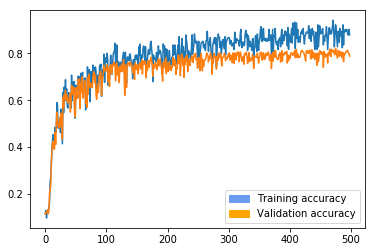

In [29]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

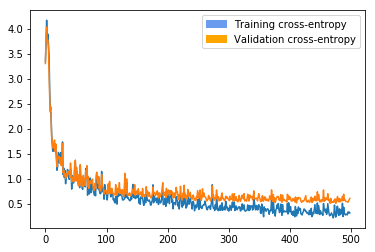

In [30]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [31]:
test_acc = session.run(accuracy, feed_dict={
    inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1., is_training: False})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.8003


In [32]:
session.close()